# Load and Inspect Data

In [1]:
import pandas as pd

# Load the dataset from GitHub
csv_url = "https://raw.githubusercontent.com/xyzesther/decoding_digital_personas/main/data/mbti_1.csv"
df = pd.read_csv(csv_url)

print(f"Dataset shape: {df.shape}\n")

df.head()

# Remove missing values and reset index
df = df.dropna().reset_index(drop=True)

# Display unique MBTI types
print("Unique MBTI Types:\n", df['type'].unique())

Dataset shape: (8675, 2)

Unique MBTI Types:
 ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


### Distribution of the data

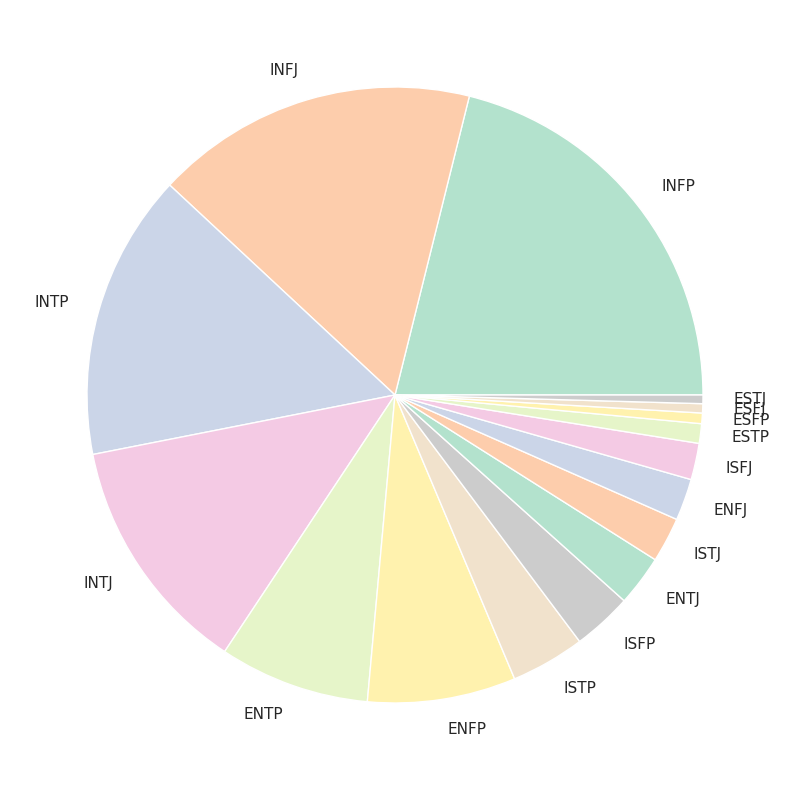

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of MBTI types
mbti_dict = df['type'].value_counts().to_dict()
mbti = list(mbti_dict.keys())
vals = list(mbti_dict.values())

sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (10,10))
plt.pie(vals, labels = mbti, colors = plt.cm.Pastel2.colors)
plt.show()

#### Distribution By MBTI Traits

In [3]:
# Convert MBTI labels into four binary features (E/I, S/N, T/F, J/P)
def mbti_to_binary(mbti_type):
    return [
        1 if mbti_type[0] == 'E' else 0,
        1 if mbti_type[1] == 'S' else 0,
        1 if mbti_type[2] == 'T' else 0,
        1 if mbti_type[3] == 'J' else 0
    ]

df[['I/E', 'N/S', 'F/T', 'P/J']] = df['type'].apply(lambda x: pd.Series(mbti_to_binary(x)))

df.head()


,type,posts,I/E,N/S,F/T,P/J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1


In [4]:
print(df["I/E"].value_counts())
print(df["N/S"].value_counts())
print(df["F/T"].value_counts())
print(df["P/J"].value_counts())

I/E
0    6676
1    1999
Name: count, dtype: int64
N/S
0    7478
1    1197
Name: count, dtype: int64
F/T
0    4694
1    3981
Name: count, dtype: int64
P/J
0    5241
1    3434
Name: count, dtype: int64


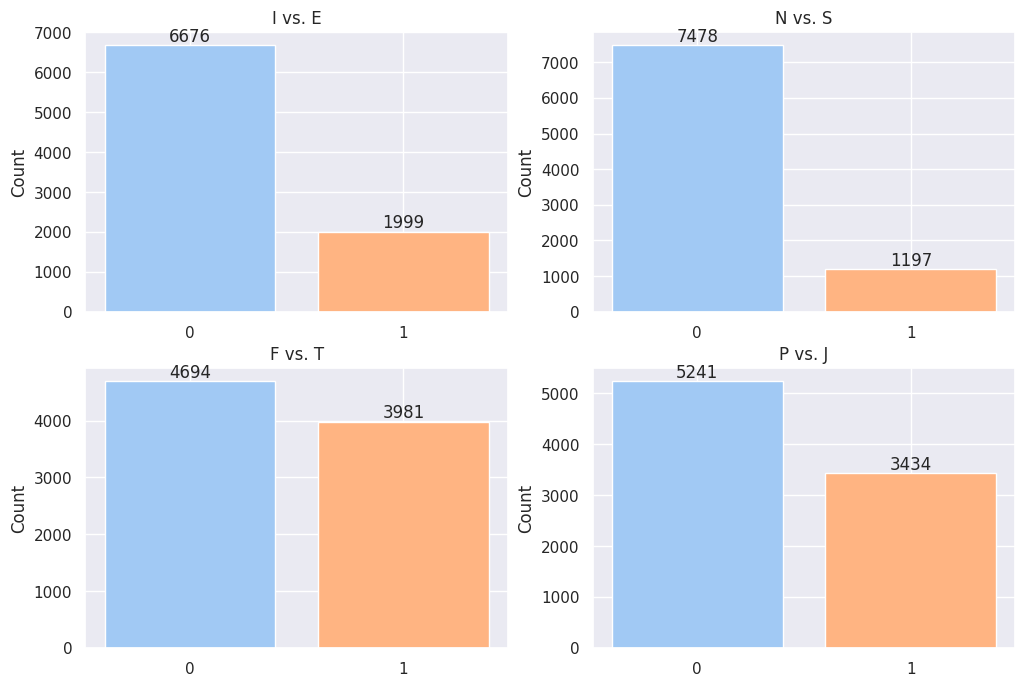

In [5]:
# Show the trait distribution in histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
colors = sns.color_palette("pastel")

def bar_plot(colors, ax, title, col):
    bars = ax.bar(x = df[col].value_counts().index,
           height=df[col].value_counts().values,
           color=colors,
           tick_label = df[col].value_counts().index)
    ax.set_title(title)
    ax.set_ylabel("Count")

    for bar in bars:
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, height,
              int(height),
              ha="center", va="bottom")

bar_plot(colors, axs[0][0], "I vs. E", "I/E" )
bar_plot(colors, axs[0][1], "N vs. S", "N/S" )
bar_plot(colors, axs[1][0], "F vs. T", "F/T")
bar_plot(colors, axs[1][1], "P vs. J", "P/J")

# Use BERT + MLP model

In [6]:
# Join the 50 posts into one text string and remove URLs
import re

def clean_and_join(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    return " ".join(text.split("|||"))

def mbti_to_binary(mbti_type):
    return [
        1 if mbti_type[0] == 'E' else 0,
        1 if mbti_type[1] == 'S' else 0,
        1 if mbti_type[2] == 'T' else 0,
        1 if mbti_type[3] == 'J' else 0
    ]

df["clean_text_bert"] = df["posts"].apply(clean_and_join)
df["labels"] = df["type"].apply(mbti_to_binary)

In [7]:
from sklearn.model_selection import train_test_split

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["clean_text_bert"].tolist(), df["labels"].tolist(), test_size=0.25, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [8]:
# Dataset class
from torch.utils.data import Dataset, DataLoader

class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors="pt", max_length=self.max_len,
                                padding="max_length", truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return inputs["input_ids"], inputs["attention_mask"], label

    def __len__(self):
        return len(self.texts)


In [9]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# BERT + MLP model
class BertMLPClassifier(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased"):
        super(BertMLPClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.classifier = nn.Sequential(
            nn.Linear(768, 50),
            nn.ReLU(),
            nn.Linear(50, 4)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(cls_output)

In [10]:
# Prepare data loaders and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = MBTIDataset(train_texts, train_labels, tokenizer)
val_dataset = MBTIDataset(val_texts, val_labels, tokenizer)
test_dataset = MBTIDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model = BertMLPClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using cuda device


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
import numpy as np

# Compute pos_weight to handle label imbalance
y_array = np.array(train_labels)
pos_weights = torch.tensor([(len(y_array) / y_array[:, i].sum()) for i in range(4)]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [12]:
# Learning rate scheduler with warmup + decay
from transformers import get_linear_schedule_with_warmup

epochs = 10
patience = 3  # for early stopping
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

In [13]:
from tqdm import tqdm

# Train the model with early stopping
best_loss = float('inf')
patience_counter = 0
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, (input_ids, attention_mask, labels) in enumerate(tqdm(train_loader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}, Step {step}: Learning Rate = {current_lr:.8f}")

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Avg Loss: {avg_loss:.4f}")

    # early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


  0%|          | 1/407 [00:02<19:24,  2.87s/it]

Epoch 1, Step 0: Learning Rate = 0.00000005


 12%|█▏        | 50/407 [01:33<11:35,  1.95s/it]

Epoch 1, Step 50: Learning Rate = 0.00000251


 25%|██▍       | 100/407 [03:05<09:30,  1.86s/it]

Epoch 1, Step 100: Learning Rate = 0.00000496


 37%|███▋      | 150/407 [04:36<07:44,  1.81s/it]

Epoch 1, Step 150: Learning Rate = 0.00000742


 49%|████▉     | 200/407 [06:06<06:18,  1.83s/it]

Epoch 1, Step 200: Learning Rate = 0.00000988


 61%|██████▏   | 250/407 [07:37<04:42,  1.80s/it]

Epoch 1, Step 250: Learning Rate = 0.00001233


 74%|███████▎  | 300/407 [09:08<03:13,  1.81s/it]

Epoch 1, Step 300: Learning Rate = 0.00001479


 86%|████████▌ | 350/407 [10:39<01:44,  1.84s/it]

Epoch 1, Step 350: Learning Rate = 0.00001725


 98%|█████████▊| 400/407 [12:09<00:12,  1.81s/it]

Epoch 1, Step 400: Learning Rate = 0.00001971


100%|██████████| 407/407 [12:21<00:00,  1.82s/it]


Epoch 1 | Avg Loss: 1.1395


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 2, Step 0: Learning Rate = 0.00001999


 12%|█▏        | 50/407 [01:44<12:42,  2.14s/it]

Epoch 2, Step 50: Learning Rate = 0.00001972


 25%|██▍       | 100/407 [03:22<11:16,  2.20s/it]

Epoch 2, Step 100: Learning Rate = 0.00001945


 37%|███▋      | 150/407 [04:54<07:44,  1.81s/it]

Epoch 2, Step 150: Learning Rate = 0.00001918


 49%|████▉     | 200/407 [06:24<06:17,  1.82s/it]

Epoch 2, Step 200: Learning Rate = 0.00001890


 61%|██████▏   | 250/407 [07:56<04:41,  1.79s/it]

Epoch 2, Step 250: Learning Rate = 0.00001863


 74%|███████▎  | 300/407 [09:27<03:14,  1.81s/it]

Epoch 2, Step 300: Learning Rate = 0.00001836


 86%|████████▌ | 350/407 [10:58<01:45,  1.85s/it]

Epoch 2, Step 350: Learning Rate = 0.00001808


 98%|█████████▊| 400/407 [12:28<00:12,  1.80s/it]

Epoch 2, Step 400: Learning Rate = 0.00001781


100%|██████████| 407/407 [12:40<00:00,  1.87s/it]


Epoch 2 | Avg Loss: 0.9856


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 3, Step 0: Learning Rate = 0.00001777


 12%|█▏        | 50/407 [01:30<10:33,  1.77s/it]

Epoch 3, Step 50: Learning Rate = 0.00001750


 25%|██▍       | 100/407 [03:01<09:10,  1.79s/it]

Epoch 3, Step 100: Learning Rate = 0.00001723


 37%|███▋      | 150/407 [04:32<08:01,  1.87s/it]

Epoch 3, Step 150: Learning Rate = 0.00001695


 49%|████▉     | 200/407 [06:04<06:47,  1.97s/it]

Epoch 3, Step 200: Learning Rate = 0.00001668


 61%|██████▏   | 250/407 [07:40<04:39,  1.78s/it]

Epoch 3, Step 250: Learning Rate = 0.00001641


 74%|███████▎  | 300/407 [09:11<03:14,  1.81s/it]

Epoch 3, Step 300: Learning Rate = 0.00001613


 86%|████████▌ | 350/407 [10:41<01:41,  1.79s/it]

Epoch 3, Step 350: Learning Rate = 0.00001586


 98%|█████████▊| 400/407 [12:12<00:12,  1.79s/it]

Epoch 3, Step 400: Learning Rate = 0.00001559


100%|██████████| 407/407 [12:24<00:00,  1.83s/it]


Epoch 3 | Avg Loss: 0.7792


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 4, Step 0: Learning Rate = 0.00001555


 12%|█▏        | 50/407 [01:30<10:48,  1.82s/it]

Epoch 4, Step 50: Learning Rate = 0.00001528


 25%|██▍       | 100/407 [03:01<09:18,  1.82s/it]

Epoch 4, Step 100: Learning Rate = 0.00001500


 37%|███▋      | 150/407 [04:32<07:40,  1.79s/it]

Epoch 4, Step 150: Learning Rate = 0.00001473


 49%|████▉     | 200/407 [06:03<06:17,  1.82s/it]

Epoch 4, Step 200: Learning Rate = 0.00001446


 61%|██████▏   | 250/407 [07:34<04:53,  1.87s/it]

Epoch 4, Step 250: Learning Rate = 0.00001419


 74%|███████▎  | 300/407 [09:05<03:11,  1.79s/it]

Epoch 4, Step 300: Learning Rate = 0.00001391


 86%|████████▌ | 350/407 [10:35<01:44,  1.84s/it]

Epoch 4, Step 350: Learning Rate = 0.00001364


 98%|█████████▊| 400/407 [12:06<00:12,  1.79s/it]

Epoch 4, Step 400: Learning Rate = 0.00001337


100%|██████████| 407/407 [12:18<00:00,  1.81s/it]


Epoch 4 | Avg Loss: 0.6373


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 5, Step 0: Learning Rate = 0.00001333


 12%|█▏        | 50/407 [01:30<10:39,  1.79s/it]

Epoch 5, Step 50: Learning Rate = 0.00001305


 25%|██▍       | 100/407 [03:01<09:19,  1.82s/it]

Epoch 5, Step 100: Learning Rate = 0.00001278


 37%|███▋      | 150/407 [04:32<07:38,  1.79s/it]

Epoch 5, Step 150: Learning Rate = 0.00001251


 49%|████▉     | 200/407 [06:03<06:13,  1.80s/it]

Epoch 5, Step 200: Learning Rate = 0.00001224


 61%|██████▏   | 250/407 [07:33<04:49,  1.85s/it]

Epoch 5, Step 250: Learning Rate = 0.00001196


 74%|███████▎  | 300/407 [09:04<03:13,  1.81s/it]

Epoch 5, Step 300: Learning Rate = 0.00001169


 86%|████████▌ | 350/407 [10:35<01:43,  1.82s/it]

Epoch 5, Step 350: Learning Rate = 0.00001142


 98%|█████████▊| 400/407 [12:06<00:12,  1.79s/it]

Epoch 5, Step 400: Learning Rate = 0.00001114


100%|██████████| 407/407 [12:18<00:00,  1.81s/it]


Epoch 5 | Avg Loss: 0.5112


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 6, Step 0: Learning Rate = 0.00001111


 12%|█▏        | 50/407 [01:30<10:40,  1.79s/it]

Epoch 6, Step 50: Learning Rate = 0.00001083


 25%|██▍       | 100/407 [03:01<09:20,  1.83s/it]

Epoch 6, Step 100: Learning Rate = 0.00001056


 37%|███▋      | 150/407 [04:32<07:40,  1.79s/it]

Epoch 6, Step 150: Learning Rate = 0.00001029


 49%|████▉     | 200/407 [06:02<06:10,  1.79s/it]

Epoch 6, Step 200: Learning Rate = 0.00001001


 61%|██████▏   | 250/407 [07:33<04:53,  1.87s/it]

Epoch 6, Step 250: Learning Rate = 0.00000974


 74%|███████▎  | 300/407 [09:04<03:12,  1.80s/it]

Epoch 6, Step 300: Learning Rate = 0.00000947


 86%|████████▌ | 350/407 [10:35<01:44,  1.82s/it]

Epoch 6, Step 350: Learning Rate = 0.00000919


 98%|█████████▊| 400/407 [12:06<00:12,  1.80s/it]

Epoch 6, Step 400: Learning Rate = 0.00000892


100%|██████████| 407/407 [12:18<00:00,  1.81s/it]


Epoch 6 | Avg Loss: 0.4098


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 7, Step 0: Learning Rate = 0.00000888


 12%|█▏        | 50/407 [01:30<10:38,  1.79s/it]

Epoch 7, Step 50: Learning Rate = 0.00000861


 25%|██▍       | 100/407 [03:01<09:18,  1.82s/it]

Epoch 7, Step 100: Learning Rate = 0.00000834


 37%|███▋      | 150/407 [04:32<07:39,  1.79s/it]

Epoch 7, Step 150: Learning Rate = 0.00000806


 49%|████▉     | 200/407 [06:02<06:12,  1.80s/it]

Epoch 7, Step 200: Learning Rate = 0.00000779


 61%|██████▏   | 250/407 [07:34<04:55,  1.89s/it]

Epoch 7, Step 250: Learning Rate = 0.00000752


 74%|███████▎  | 300/407 [09:04<03:11,  1.79s/it]

Epoch 7, Step 300: Learning Rate = 0.00000725


 86%|████████▌ | 350/407 [10:35<01:43,  1.82s/it]

Epoch 7, Step 350: Learning Rate = 0.00000697


 98%|█████████▊| 400/407 [12:05<00:12,  1.79s/it]

Epoch 7, Step 400: Learning Rate = 0.00000670


100%|██████████| 407/407 [12:17<00:00,  1.81s/it]


Epoch 7 | Avg Loss: 0.3345


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 8, Step 0: Learning Rate = 0.00000666


 12%|█▏        | 50/407 [01:30<10:45,  1.81s/it]

Epoch 8, Step 50: Learning Rate = 0.00000639


 25%|██▍       | 100/407 [03:01<09:22,  1.83s/it]

Epoch 8, Step 100: Learning Rate = 0.00000612


 37%|███▋      | 150/407 [04:32<07:39,  1.79s/it]

Epoch 8, Step 150: Learning Rate = 0.00000584


 49%|████▉     | 200/407 [06:02<06:16,  1.82s/it]

Epoch 8, Step 200: Learning Rate = 0.00000557


 61%|██████▏   | 250/407 [07:34<04:51,  1.86s/it]

Epoch 8, Step 250: Learning Rate = 0.00000530


 74%|███████▎  | 300/407 [09:04<03:10,  1.78s/it]

Epoch 8, Step 300: Learning Rate = 0.00000502


 86%|████████▌ | 350/407 [10:35<01:45,  1.84s/it]

Epoch 8, Step 350: Learning Rate = 0.00000475


 98%|█████████▊| 400/407 [12:06<00:12,  1.79s/it]

Epoch 8, Step 400: Learning Rate = 0.00000448


100%|██████████| 407/407 [12:17<00:00,  1.81s/it]


Epoch 8 | Avg Loss: 0.2792


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 9, Step 0: Learning Rate = 0.00000444


 12%|█▏        | 50/407 [01:30<10:44,  1.80s/it]

Epoch 9, Step 50: Learning Rate = 0.00000417


 25%|██▍       | 100/407 [03:01<09:22,  1.83s/it]

Epoch 9, Step 100: Learning Rate = 0.00000389


 37%|███▋      | 150/407 [04:32<07:41,  1.80s/it]

Epoch 9, Step 150: Learning Rate = 0.00000362


 49%|████▉     | 200/407 [06:03<06:14,  1.81s/it]

Epoch 9, Step 200: Learning Rate = 0.00000335


 61%|██████▏   | 250/407 [07:34<04:53,  1.87s/it]

Epoch 9, Step 250: Learning Rate = 0.00000307


 74%|███████▎  | 300/407 [09:04<03:13,  1.81s/it]

Epoch 9, Step 300: Learning Rate = 0.00000280


 86%|████████▌ | 350/407 [10:35<01:43,  1.82s/it]

Epoch 9, Step 350: Learning Rate = 0.00000253


 98%|█████████▊| 400/407 [12:06<00:12,  1.80s/it]

Epoch 9, Step 400: Learning Rate = 0.00000225


100%|██████████| 407/407 [12:18<00:00,  1.81s/it]


Epoch 9 | Avg Loss: 0.2425


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 10, Step 0: Learning Rate = 0.00000222


 12%|█▏        | 50/407 [01:30<10:43,  1.80s/it]

Epoch 10, Step 50: Learning Rate = 0.00000194


 25%|██▍       | 100/407 [03:01<09:17,  1.81s/it]

Epoch 10, Step 100: Learning Rate = 0.00000167


 37%|███▋      | 150/407 [04:32<07:36,  1.78s/it]

Epoch 10, Step 150: Learning Rate = 0.00000140


 49%|████▉     | 200/407 [06:02<06:11,  1.80s/it]

Epoch 10, Step 200: Learning Rate = 0.00000112


 61%|██████▏   | 250/407 [07:33<04:52,  1.86s/it]

Epoch 10, Step 250: Learning Rate = 0.00000085


 74%|███████▎  | 300/407 [09:04<03:12,  1.80s/it]

Epoch 10, Step 300: Learning Rate = 0.00000058


 86%|████████▌ | 350/407 [10:35<01:44,  1.83s/it]

Epoch 10, Step 350: Learning Rate = 0.00000031


 98%|█████████▊| 400/407 [12:05<00:12,  1.80s/it]

Epoch 10, Step 400: Learning Rate = 0.00000003


100%|██████████| 407/407 [12:17<00:00,  1.81s/it]


Epoch 10 | Avg Loss: 0.2226


In [14]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

print("Validation Set Performance:")
y_true_val, y_pred_val = [], []
model.eval()
with torch.no_grad():
    for input_ids, attention_mask, labels in tqdm(val_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        y_pred_val.extend(preds)
        y_true_val.extend(labels.numpy())

print("\n"+classification_report(
    np.array(y_true_val),
    np.array(y_pred_val),
    target_names=["I/E", "N/S", "F/T", "P/J"],
    zero_division=0
))


Validation Set Performance:


100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


              precision    recall  f1-score   support

         I/E       0.57      0.71      0.63       221
         N/S       0.63      0.64      0.64       157
         F/T       0.82      0.83      0.83       483
         P/J       0.69      0.72      0.71       427

   micro avg       0.71      0.75      0.73      1288
   macro avg       0.68      0.73      0.70      1288
weighted avg       0.71      0.75      0.73      1288
 samples avg       0.57      0.59      0.57      1288



In [15]:
# Evaluate the model on test set
print("Test Set Performance:")
y_true_test, y_pred_test = [], []
model.eval()
with torch.no_grad():
    for input_ids, attention_mask, labels in tqdm(test_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        y_pred_test.extend(preds)
        y_true_test.extend(labels.numpy())

print("\n"+classification_report(
    np.array(y_true_test), np.array(y_pred_test),
    target_names=["I/E", "N/S", "F/T", "P/J"],
    zero_division=0
))


Test Set Performance:


100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


              precision    recall  f1-score   support

         I/E       0.58      0.70      0.63       252
         N/S       0.67      0.63      0.65       150
         F/T       0.80      0.84      0.82       507
         P/J       0.68      0.78      0.73       415

   micro avg       0.70      0.77      0.73      1324
   macro avg       0.68      0.74      0.71      1324
weighted avg       0.71      0.77      0.74      1324
 samples avg       0.58      0.60      0.57      1324



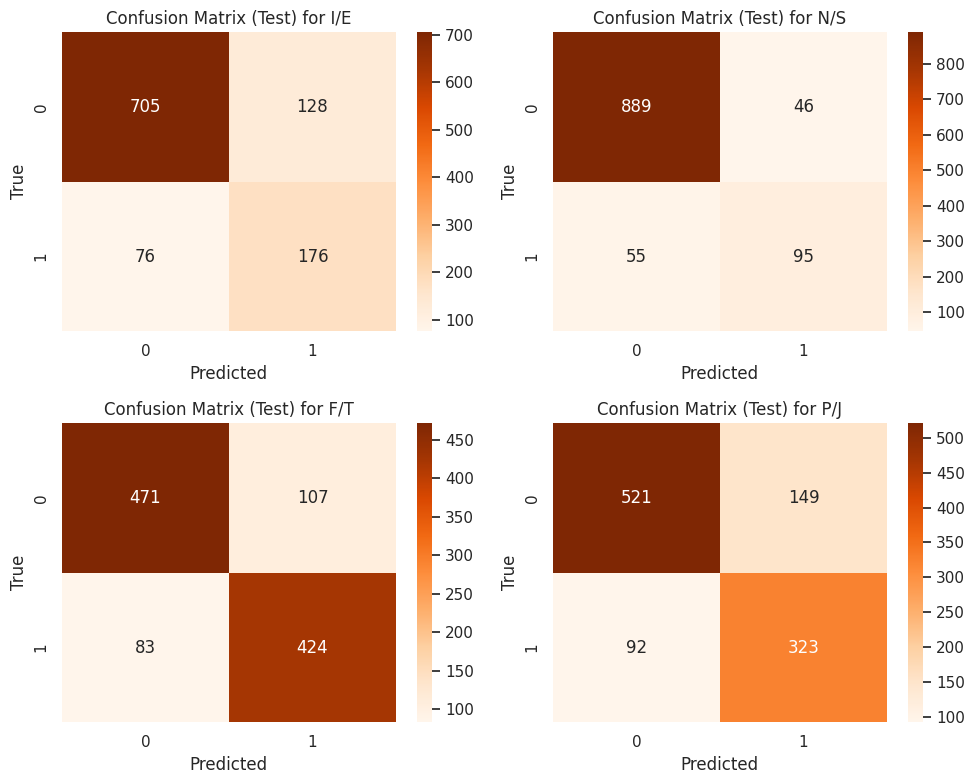

In [18]:
# Confusion matrix for test set
conf_matrices_test = multilabel_confusion_matrix(y_true_test, y_pred_test)
labels = ["I/E", "N/S", "F/T", "P/J"]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i in range(4):
    row, col = i // 2, i % 2
    sns.heatmap(conf_matrices_test[i], annot=True, fmt='d', cmap="Oranges", ax=axes[row][col])
    axes[row][col].set_title(f"Confusion Matrix (Test) for {labels[i]}")
    axes[row][col].set_xlabel("Predicted")
    axes[row][col].set_ylabel("True")
plt.tight_layout()
plt.show()

In [21]:
# Predict MBTI traits for a single input text
def predict_mbti(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        binary_output = [1 if p >= 0.5 else 0 for p in probs]
        mbti_traits = ["E" if binary_output[0] else "I",
                       "S" if binary_output[1] else "N",
                       "T" if binary_output[2] else "F",
                       "J" if binary_output[3] else "P"]
        return "".join(mbti_traits), probs

example_text = "I love exploring new places and meeting people. I tend to be logical and like to make decisions quickly."
pred_type, confidence = predict_mbti(example_text)
print(f"Predicted MBTI type: {pred_type}")
print(f"Trait confidences: {confidence}")


Predicted MBTI type: ISTP
Trait confidences: [0.44119862 0.9614867  0.7166388  0.07651575]
